# Antoni Kobosz
### HW6

In [275]:
import numpy as np , pandas as pd, matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import seaborn as sns
from word2number import w2n
import warnings 
warnings.filterwarnings("ignore")
from matplotlib.ticker import MaxNLocator

pio.templates.default = "plotly_white"


df = pd.read_csv("chess+king+rook+vs+king/krkopt.data",
                 header = None,
                 names = ['white-king-file','white-king-rank',
                          'white-rook-file','white-rook-rank',
                          'black-king-file','black-king-rank',
                          'white-depth-of-win'])

# Zamieniam współrzędne z [a,...,h] na [1,...,8], a 'white-depth-of-win' na liczby.
df[['white-king-file','white-rook-file','black-king-file']] = df[['white-king-file','white-rook-file','black-king-file']].map(lambda x: ord(x) - ord('a')+1)
df['white-depth-of-win'] = df['white-depth-of-win'].apply(
    lambda x: -1 if x == 'draw' else w2n.word_to_num(x)
).astype(int)

## Pytanie 1
Gdzie zwykle znajduje się na planszy czarny król, kiedy jest matowany (white-depth-of-win=0)? Gdzie znajduje się, kiedy gra kończy się remisem (white-depth-of-win=-1)?


In [276]:
BK_mates = df.loc[df['white-depth-of-win'] == 0,['black-king-file','black-king-rank']].value_counts().reset_index()
BK_draws = df.loc[df['white-depth-of-win'] == -1,['black-king-file','black-king-rank']].value_counts().reset_index()
BK_mates_sum = BK_mates.pivot(columns='black-king-file',values='count',index='black-king-rank').fillna(0)
BK_mates_sum = BK_mates_sum.reindex(index=range(1,9),columns=range(1,9),fill_value=0)

BK_draws_sum = BK_draws.pivot(columns='black-king-file',values='count',index='black-king-rank').fillna(0)
BK_draws_sum = BK_draws_sum.reindex(index=range(1,9),columns=range(1,9),fill_value=0)

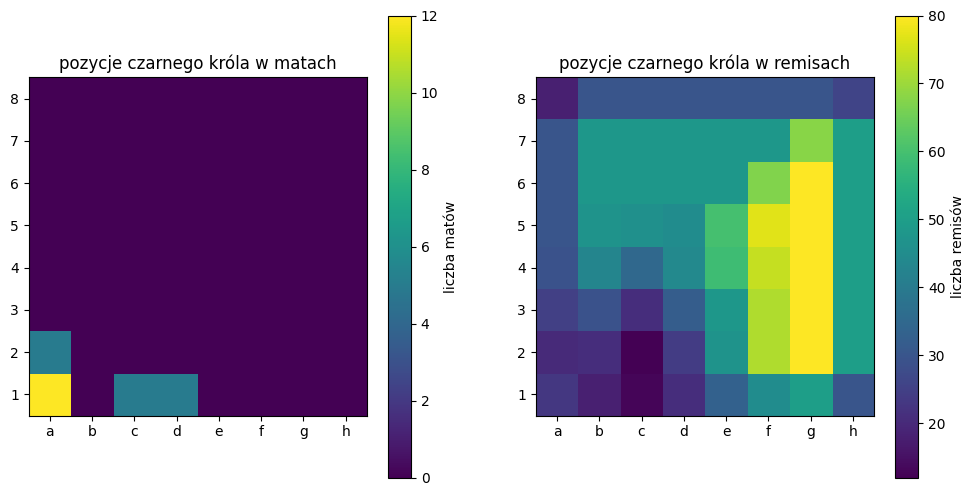

In [277]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
im1 = ax[0].imshow(BK_mates_sum,origin='lower')
cbar1 = plt.colorbar(im1,ax=ax[0]).set_label("liczba matów")
ax[0].set_title("pozycje czarnego króla w matach")
ax[0].set_yticks(range(8))
ax[0].set_yticklabels(range(1,9)) 

ax[0].set_xticks(range(8))
ax[0].set_xticklabels(list('abcdefgh'))


im2 = ax[1].imshow(BK_draws_sum,origin='lower')
ax[1].set_title("pozycje czarnego króla w remisach")
plt.colorbar(im2,ax=ax[1]).set_label("liczba remisów")

ax[1].set_yticks(range(8))
ax[1].set_yticklabels(range(1,9)) 

ax[1].set_xticks(range(8))
ax[1].set_xticklabels(list('abcdefgh'))
plt.show()

Odp. Najczęściej jest matowany  w rogu planszy, a najwięcej remisów jest w rejonie środka

## Pytanie 2
Jednym z istotnych czynników tego, w ilu ruchach gra się zakończy jest dystans pomiędzy białym królem a czarnym królem. Jaka metryka dystansu (Euklidesowa, Manhattan, lub Czebyszewa) pomiędzy nimi pozwoli najlepiej oszacować liczbę ruchów do zakończenia gry? Do tej analizy zignoruj sytuacje remisowe (white-depth-of-win = -1).

In [278]:
df2 = df.loc[df['white-depth-of-win']!=-1].copy()
df2['euk'] = np.sqrt((df['white-king-file'] - df['black-king-file'])**2 + (df['white-king-rank']-df['black-king-rank'])**2)
df2['manh'] = np.abs(df['white-king-file'] - df['black-king-file']) + np.abs(df['white-king-rank']-df['black-king-rank'])
df2['czeb'] = np.maximum(np.abs(df['white-king-file'] - df['black-king-file']),np.abs(df['white-king-rank']-df['black-king-rank']))

# To na później
df2['edge_dist'] = np.minimum(
    np.minimum(df2['black-king-file']-1, df2['black-king-rank']-1),
    np.minimum(8 - df2['black-king-file'], 8 - df2['black-king-rank'])
) 

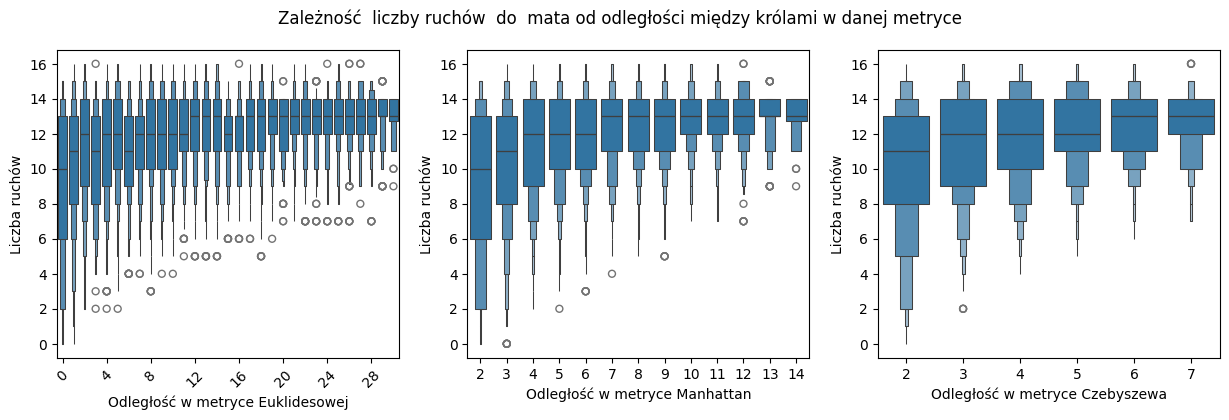

In [315]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

sns.boxenplot(df2,x='euk',y='white-depth-of-win',ax=ax[0])
sns.boxenplot(df2,x='manh',y='white-depth-of-win',ax=ax[1])
sns.boxenplot(df2,x='czeb',y='white-depth-of-win',ax=ax[2])
for a in ax:
    a.set_ylabel('Liczba ruchów')
ax[0].set_xlabel('Odległość w metryce Euklidesowej')
ax[1].set_xlabel('Odległość w metryce Manhattan')
ax[2].set_xlabel('Odległość w metryce Czebyszewa')
ax[0].tick_params(axis='x', rotation=45)
ax[0].xaxis.set_major_formatter('{:.0f}'.format)
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=9))  # maksymalnie 6 ticków
fig.suptitle('Zależność  liczby ruchów  do  mata '
            'od odległości między królami w danej metryce')
plt.show()

Z samych wykresów trudno odczytać, która metryka najlepiej przewiduje liczbę ruchów do mata. \
Obliczmy współczynniki korelacji

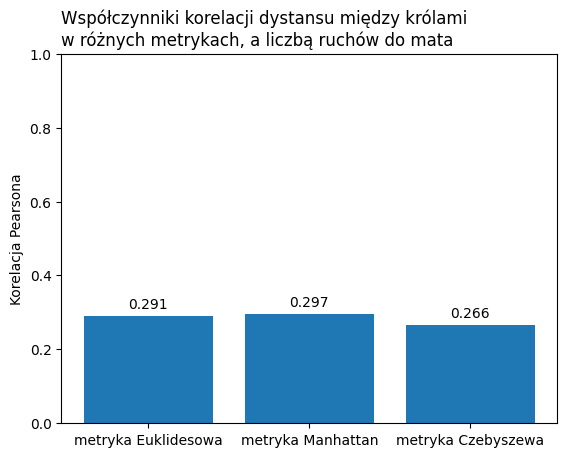

In [280]:
korelacje = df2[['euk','manh','czeb']].corrwith(df2['white-depth-of-win']).reset_index(name='corr').rename(columns={'index':'metryka'})
fig, ax = plt.subplots()
bars = ax.bar(korelacje['metryka'], korelacje['corr'])
ax.set_ylim([0,1])
ax.set_ylabel("Korelacja Pearsona")

ax.bar_label(bars, fmt="%.3f", padding=3)  
ax.set_xticklabels(['metryka Euklidesowa', 'metryka Manhattan', 'metryka Czebyszewa'])

ax.set_title('Współczynniki korelacji dystansu między królami \nw różnych metrykach, a liczbą ruchów do mata',loc='left')
plt.show()

Największy współczynnik korelacji jest dla metryki Manhattan, choć jest to niewielka różnica. W dalszej części skupie się na metryce Czebyszewa, ponieważ w naturalny sposób opisuje ona  liczbę kroków jaką król musi zrobić żeby przejść od A do B

## Pytanie 3
Czy informacja o odległości czarnego króla od krawędzi planszy może być przydatna w określeniu w ilu ruchach zakończy się gra? Czy uzupełnienie tej informacji o odległość pomiędzy białym a czarnym królem z poprzedniego zadania może dodatkowo pomóc? Do tej analizy zignoruj sytuacje remisowe (white-depth-of-win = -1).

*Zauważmy, że w każdej z metryk odległość od ścianki jest taka sama

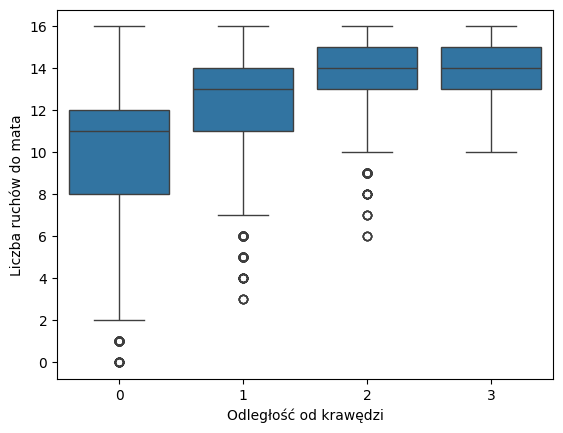

In [295]:
sns.boxplot(df2,x='edge_dist',y='white-depth-of-win')
plt.xlabel('Odległość od krawędzi')
plt.ylabel('Liczba ruchów do mata')
plt.show()

Obliczmy współczynnik korelacji 

In [312]:
kor = round(df2[['edge_dist']].corrwith(df2['white-depth-of-win']).reset_index(drop=True).iloc[0],3)
print(f'Korelacja między odległością od krawędzi, liczbą ruchów wynosi: {kor}')


Korelacja między odległością od krawędzi, liczbą ruchów wynosi: 0.508


Jak odległość od ścianki wpływa na zadanie 2?

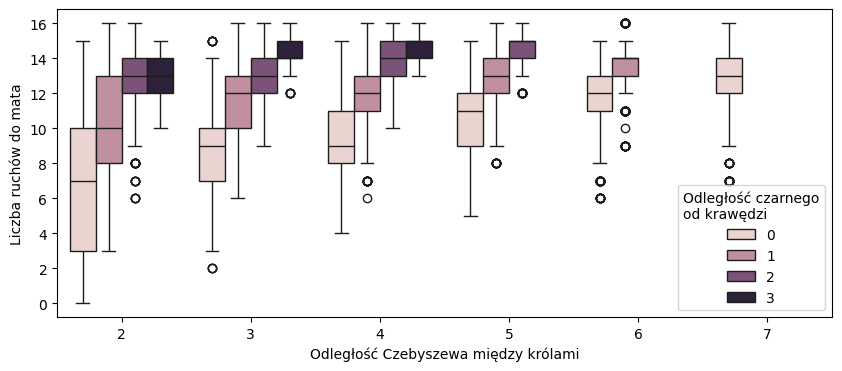

In [342]:
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=df2,x='czeb',y='white-depth-of-win',hue='edge_dist')
plt.xlabel('Odległość Czebyszewa między królami')
plt.ylabel('Liczba ruchów do mata')
ax.legend(title='Odległość czarnego\nod krawędzi')
plt.show()

Wygląda na to, że odległość czarnego króla od krawędzi liniowo wpływa na Liczbę ruchów do mata \
Obliczmy współczynnik korelacji sumy odległości czebyszewa i od krawędzi dla różnych parametrów a
```
Z = df2['czeb'] + a*df2['edge_dist']
```

In [397]:
a = 2
Z = df2['czeb'] + a*df2['edge_dist']
df[['white-depth-of-win']].corrwith(Z)

white-depth-of-win    0.696235
dtype: float64

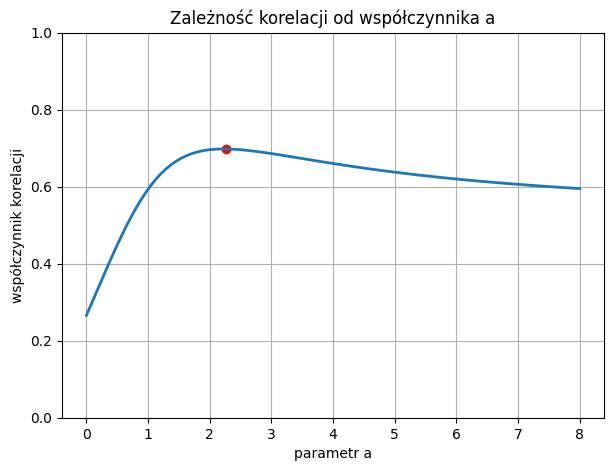

In [414]:
a_values = np.linspace(0, 8, 100)  # zakres a do przetestowania
corr_values = []

for a in a_values:
    Z = df2['czeb'] + a * df2['edge_dist']
    corr = df2['white-depth-of-win'].corr(Z)
    corr_values.append(corr)

plt.figure(figsize=(7,5))
plt.plot(a_values, corr_values, lw=2)
plt.ylim(0,1)
plt.xlabel('parametr a')
plt.ylabel('współczynnik korelacji')
plt.title('Zależność korelacji od współczynnika a')
plt.grid(True)

i = np.argmax(corr_values)
plt.scatter(x=a_values[i],y=corr_values[i],color='red')

plt.show()

Najwyższą korelację odczytuję z wykresu dla a=2

In [415]:
a = 2
Z = df2['czeb'] + a*df2['edge_dist']
df[['white-depth-of-win']].corrwith(Z)

white-depth-of-win    0.696235
dtype: float64

Wniosek: 
$$
\text{Liczba ruchów do mata }\sim\text{odległość czebyszewa między królami} + 2\cdot\text{odległość czarnego króla od ścianki}
$$